In [63]:
import cv2
import numpy as np
import os, json
import matplotlib.pyplot as plt

# Instrinsic parameters

In [64]:
fx = 714.1526
fy = 710.3725
cx = 713.85
cy = 327
camera_h = 1.8
cameraMatrix = np.array([[fx, 0, cx], [0, fy, cy], [0,0,1]])

In [65]:
cameraMatrix

array([[714.1526,   0.    , 713.85  ],
       [  0.    , 710.3725, 327.    ],
       [  0.    ,   0.    ,   1.    ]])

# Training set

In [66]:
def read_json(if_test=0):
    # specify the path of the annotation file
    json_path = 'annotation.json'
    
    # specify the folder and subfolder paths for all training data and test data
    if if_test == 0:
        dataset_path = 'benchmark_velocity_train/clips/'
        folder_path = [str(x+1) for x in range(1074)]
    else:
        dataset_path = 'benchmark_velocity_test/clips/'
        folder_path = [str(x+1) for x in range(269)]
        
    json_paths = [os.path.join(dataset_path, x, json_path) for x in folder_path]
    
    # Now we have all the paths for the json ready, then we start reading all json object
    json_dataset = []
    for path in json_paths:
        with open(path) as json_file:
            json_dataset.append(json.load(json_file))
        
    return json_dataset

train_dataset = read_json(if_test = 0)
json_test_data = read_json(if_test = 1)

# Test set

In [67]:
with open("gt.json") as json_file:
    test_dataset = json.load(json_file)

# Function to calculated the width

In [68]:
def calculate_width(position, bbox):
    focallen = fx
    d = position[0]
    w = bbox['right'] - bbox['left']
    return d * w / focallen


In [69]:
def calculate_average_width(dataset):
    widths = []
    for i, img in enumerate(dataset):
        for vehicle in img:
            bbox = vehicle["bbox"]
            position = vehicle["position"]
            widths.append(calculate_width(position, bbox))

    width = np.average(widths)
    print(f"average inferred width is {width}")
    return width
    


In [70]:
calculate_average_width(test_dataset)
calculate_average_width(train_dataset)

average inferred width is 2.1564655889878255
average inferred width is 2.156722303337916


2.156722303337916

# Calculate vehicles' distance

In [71]:
def calculate_distance_compare(width, position, bbox):
    focallen = fx
    w = bbox['right'] - bbox['left']
    calculated_distance = width * focallen / w 
    true_distance = position[0]
    
    true_x1 = position[1]
    if bbox["left"] >= cx:
        calculated_x1 = (bbox["left"] - cx) * calculated_distance / focallen
    elif bbox["right"] <= cx:
        calculated_x1 = (bbox["right"] - cx) * calculated_distance / focallen
    else:
        calculated_x1 = 0
    #calculated_x1 = (bbox["right"] - cx) * calculated_distance / focallen
    #print(f"calculated_distance: {calculated_distance}, true_distance: {true_distance}, diff: {abs(calculated_distance - true_distance)}")
    
    return abs(calculated_distance - true_distance), abs(calculated_x1 - true_x1)

In [72]:
def calculate_all_distance(dataset, width = 2.156722303337916):

    diff_dist = []
    diff_x1 = []
    num = 0
    
    for i, img in enumerate(dataset):
        for vehicle in img:
            num +=1
            bbox = vehicle["bbox"]
            position = vehicle["position"]
            diff_dist.append(calculate_distance_compare(width, position, bbox)[0])
            diff_x1.append(calculate_distance_compare(width, position, bbox)[1])

    average_diff_error = np.average(diff_dist)
    average_x1_error = np.average(diff_x1)
    print(f"average difference error is {average_diff_error}, average x1 error is {average_x1_error}, total number of cars is {num}")
    return average_diff_error, average_x1_error

calculate_all_distance(test_dataset)
calculate_all_distance(train_dataset)

average difference error is 4.079268532402833, average x1 error is 1.196513481513931, total number of cars is 375
average difference error is 3.862720911350799, average x1 error is 1.1412810402533935, total number of cars is 1442


(3.862720911350799, 1.1412810402533935)

# Try features, x1, y1, pixel_w, pixel_h and predict w, and then apply triangle similarity

In [73]:
def calculate_width(bbox):
    x1 = bbox["left"]
    y1 = bbox["top"]
    pixel_w = bbox["right"] - bbox["left"]
    pixel_h = bbox["bottom"] - bbox["top"]
    return -0.000370201424067597 * x1-0.03435506853204499 * y1 + 0.02162694987625107 * pixel_w -0.03347930649287277 * pixel_h + 14.252734275136223

In [74]:
def calculate_distance_with_width(dataset):
    diff_dist = []
    diff_x1 = []
    num = 0

    for i, img in enumerate(dataset):
        for vehicle in img:
            num +=1
            bbox = vehicle["bbox"]
            position = vehicle["position"]
            width = calculate_width(bbox)
            calculate_distance_compare(width, position, bbox)
            diff_dist.append(calculate_distance_compare(width, position, bbox)[0])
            diff_x1.append(calculate_distance_compare(width, position, bbox)[1])

    average_diff_error = np.average(diff_dist)
    average_x1_error = np.average(diff_x1)
    print(f"average difference error is {average_diff_error}, average x1 error is {average_x1_error}, total number of cars is {num}")
    return average_diff_error, average_x1_error
calculate_distance_with_width(train_dataset)
calculate_distance_with_width(test_dataset)


average difference error is 2.5272064804064818, average x1 error is 1.0321139891706026, total number of cars is 1442
average difference error is 2.61775407805404, average x1 error is 1.093670718886711, total number of cars is 375


(2.61775407805404, 1.093670718886711)

# using y1, pixel_w, piexel_h, pixel_w * pixel_h to predict w and then apply triangle similarity

In [75]:
def calculate_width(bbox):
    x1 = bbox["left"]
    y1 = bbox["top"]
    pixel_w = bbox["right"] - bbox["left"]
    pixel_h = bbox["bottom"] - bbox["top"]
    return -0.030522707866872622 * y1 + 0.019645624118997243 * pixel_w -0.026543674714586008* pixel_h + -1.3394041753397261e-05 * pixel_w * pixel_h+ 12.566680966429356


In [76]:
calculate_distance_with_width(train_dataset)
calculate_distance_with_width(test_dataset)

average difference error is 2.459749025586534, average x1 error is 1.013602753223869, total number of cars is 1442
average difference error is 2.5533224723483103, average x1 error is 1.0723804459770387, total number of cars is 375


(2.5533224723483103, 1.0723804459770387)

# Use Distance from height method on training dataset

In [77]:
def distance_from_height(width, position, bbox):
    h = abs(bbox["bottom"] - cy)
    calculated_distance = fy * camera_h / h
    focallen = fx

    true_distance = position[0]
    true_x1 = position[1]
    if bbox["left"] >= cx:
        calculated_x1 = (bbox["left"] - cx) * calculated_distance / focallen
    elif bbox["right"] <= cx:
        calculated_x1 = (bbox["right"] - cx) * calculated_distance / focallen
    else:
        calculated_x1 = 0
    #print(f"calculated_distance: {calculated_distance}, true_distance: {true_distance}, diff: {abs(calculated_distance - true_distance)}")
    
    return abs(calculated_distance - true_distance), abs(calculated_x1 - true_x1)

In [78]:
# use pixel_w, piexel_h, pixel_w * pixel_h
def calculate_width(bbox):
    x1 = bbox["left"]
    y1 = bbox["top"]
    pixel_w = bbox["right"] - bbox["left"]
    pixel_h = bbox["bottom"] - bbox["top"]
    return -0.030522707866872622 * y1 + 0.019645624118997243 * pixel_w -0.026543674714586008* pixel_h + -1.3394041753397261e-05 * pixel_w * pixel_h+ 12.566680966429356


In [79]:
diff_dist = []
diff_x1 = []
num = 0
    
for i, img in enumerate(train_dataset):
    for vehicle in img:
        num +=1
        bbox = vehicle["bbox"]
        position = vehicle["position"]
        width = calculate_width(bbox)
        diff_dist.append(distance_from_height(width, position, bbox)[0])
        diff_x1.append(distance_from_height(width, position, bbox)[1])
        
average_diff_error = np.average(diff_dist)
average_x1_error = np.average(diff_x1)
print(f"average difference error is {average_diff_error}, average x1 error is {average_x1_error}, total number of cars is {num}")

average difference error is 9.329643608087732, average x1 error is 1.0303799092294204, total number of cars is 1442


In [80]:
with open("gt.json") as json_file:
    dataset = json.load(json_file)
    
diff_dist = []
diff_x1 = []
num = 0
    
for i, img in enumerate(dataset):
    for vehicle in img:
        num +=1
        bbox = vehicle["bbox"]
        position = vehicle["position"]
        width = calculate_width(bbox)
        diff_dist.append(distance_from_height(width, position, bbox)[0])
        diff_x1.append(distance_from_height(width, position, bbox)[1])
        
average_diff_error = np.average(diff_dist)
average_x1_error = np.average(diff_x1)
print(f"average difference error is {average_diff_error}, average x1 error is {average_x1_error}, total number of cars is {num}")

average difference error is 9.812869936906658, average x1 error is 1.038357445233201, total number of cars is 375


# Testing

In [81]:
test_box_40 = {"left":780, "top":330, 'right':870, "bottom":400} # right - left = 90
test_box_39 = {"left":784, "top": 340, "right": 868, "bottom":393} # right - left = 84

In [82]:
def calculate_distance(bbox):
    
    focallen = fx
    #width = calculate_width(bbox)
    #print(width)
    width = 2.156
    w = bbox['right'] - bbox['left']
    calculated_distance = width * focallen / w
    print(calculated_distance)
    return calculated_distance

In [83]:
calculate_distance(test_box_39)

18.329916733333334


18.329916733333334

In [84]:
calculate_distance(test_box_40)

17.107922284444445


17.107922284444445

benchmark_velocity_train/clips/1/imgs/039.jpg


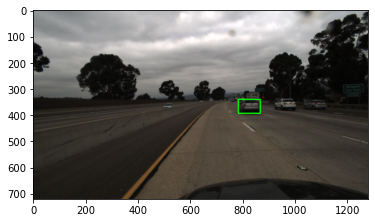

In [85]:
%matplotlib inline
import os, json, shutil
import numpy as np
import cv2

path= "benchmark_velocity_train/clips/1/imgs/039.jpg"
print(path)
img = cv2.imread(path,1)
rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
cv2.rectangle(rgb_img, (test_box_39["left"],test_box_39["top"]), (test_box_39["right"], test_box_39["bottom"]),(0, 255, 0), 3)
plt.imshow(rgb_img)

benchmark_velocity_train/clips/1/imgs/040.jpg


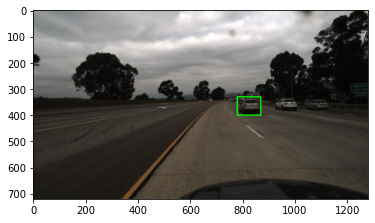

In [86]:
path= "benchmark_velocity_train/clips/1/imgs/040.jpg"
print(path)
img = cv2.imread(path,1)
rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
cv2.rectangle(rgb_img, (test_box_40["left"],test_box_40["top"]), (test_box_40["right"], test_box_40["bottom"]),(0, 255, 0), 3)
plt.imshow(rgb_img)

# New methods

In [87]:
def distance_final(position, bbox, p1 = 670):
    z0 = position[0]
    x0 = position[1]
    x1 = bbox["left"]
    y1 = bbox["top"]
    pixel_w = bbox["right"] - bbox["left"]
    pixel_h = bbox["bottom"] - bbox["top"]
    w = -0.030522707866872622 * y1 + 0.019645624118997243 * pixel_w -0.026543674714586008* pixel_h + -1.3394041753397261e-05 * pixel_w * pixel_h+ 12.566680966429356
    
    pred_z0 = w * fx / pixel_w
    
    if pred_z0 > 45:
        #[-0.028121  ,  0.01575292, -0.08113623,  0.00143413]),12.180052129300515
        w = -0.028121 * y1 + 0.01575292 * pixel_w - 0.08113623 * pixel_h +0.00143413 *  pixel_w * pixel_h + 12.180052129300515
    elif pred_z0 <= 45 and pred_z0 > 20:
        #[-0.03920957,  0.03809848, -0.02960555, -0.00017222]),15.04862701217894)
        w = -0.03920957 * y1 + 0.03809848 * pixel_w -0.02960555 * pixel_h -0.00017222 *  pixel_w * pixel_h + 15.04862701217894
    else:
        #[-2.23215766e-02,  1.42389457e-02, -2.57650913e-02,  4.97360611e-06]),10.143259937723007)
        w = -2.23215766e-02 * y1 + 1.42389457e-02 * pixel_w -2.57650913e-02 * pixel_h + 4.97360611e-06 *  pixel_w * pixel_h + 10.143259937723007
    
    #recalculate
    pred_z0 = fx * w / pixel_w
        
    pred_x0 = (x1 - p1) * pred_z0 / fx
    diff_x0 = x0 - pred_x0
    diff_z0 = z0 - pred_z0
    
    return abs(diff_z0), abs(diff_x0)

In [89]:
def calculate_distance_final(dataset):
    diff_dist = []
    diff_x1 = []
    num = 0

    for i, img in enumerate(dataset):
        for vehicle in img:
            num +=1
            bbox = vehicle["bbox"]
            position = vehicle["position"]
            diff_dist.append(distance_final(position, bbox)[0])
            diff_x1.append(distance_final(position, bbox)[1])

    average_diff_error = np.average(diff_dist)
    average_x1_error = np.average(diff_x1)
    print(f"average difference error is {average_diff_error}, average x1 error is {average_x1_error}, total number of cars is {num}")
    return average_diff_error, average_x1_error

calculate_distance_final(train_dataset)
calculate_distance_final(test_dataset)

average difference error is 2.290836593560304, average x1 error is 0.48536141495921503, total number of cars is 1442
average difference error is 2.4224110871140447, average x1 error is 0.5077497556493481, total number of cars is 375


(2.4224110871140447, 0.5077497556493481)